In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.coordinates import EarthLocation, get_body
from astropy import units as u
from panlib import getcolorim  # Pan-STARRS images
from sgl_lib import sgl_position, sgl_position_scatter

Define object of interest and planned observation time from Earth

In [4]:
object_name = 'Tau Ceti'   # Tau Ceti
observation_time = 2022.2 * u.year # UTC time of planned observation from Earth

Use object name to pull the Gaia DR2 identifier from Vizier

In [5]:
result = str(Simbad.query_objectids(object_name))
position = result.find('Gaia DR2 ') + 9
gaia_ID = result[position:position+19]
print('Gaia ID:', gaia_ID)

Gaia ID: 2452378776434276992


With this Gaia ID we pull the catalog data of object position, parallax, and proper motion

In [6]:
result = Vizier().query_constraints(Source=gaia_ID, catalog="I/345/gaia2")[0][:][0]
RA     = result['RA_ICRS']   * u.degree      # Position in RA, epoch 2015.5
e_RA   = result['e_RA_ICRS'] * u.arcsec      # Uncertainty in the position in RA
DE     = result['DE_ICRS']   * u.degree      # Position in DE, epoch 2015.5
e_DE   = result['e_DE_ICRS'] * u.arcsec      # Uncertainty in the position in DE
Plx    = result['Plx']    / 1000 * u.arcsec  # Parallax (as)
e_Plx  = result['e_Plx']  / 1000 * u.arcsec  # Uncertainty in the parallax (as)

pmRA   = result['pmRA']   / 1000 * u.arcsec / u.year  # proper motion in RA (as/yr)
e_pmRA = result['e_pmRA'] / 1000 * u.arcsec / u.year  # proper motion in DE (as/yr)
pmDE   = result['pmDE']   / 1000 * u.arcsec / u.year  # Uncertainty in the proper motion in RA (as/yr)
e_pmDE = result['e_pmDE'] / 1000 * u.arcsec / u.year  # Uncertainty in the proper motion in DE (as/yr)

# Derived values
epoch = 2015.5 * u.year  # Gaia epoch J2015.5 for DR2
distance = Plx.to(u.parsec, equivalencies=u.parallax())
distance_uncertainty = - distance + (Plx - e_Plx).to(u.parsec, equivalencies=u.parallax())

print('RA', RA, '+-', e_RA)
print('DE', DE, '+-', e_DE)
print('Plx (as)', Plx, '+-', e_Plx)
print('Proper motion in RA (as/yr)', pmRA, '+-', e_pmRA)
print('Proper motion in DE (as/yr)', pmDE, '+-', e_pmDE)
print('Distance (pc)', distance, '+-', distance_uncertainty)

RA 26.00930287667 deg +- 0.4122 arcsec
DE -15.93379865094 deg +- 0.3505 arcsec
Plx (as) 0.27751620000000005 arcsec +- 0.000517300009727478 arcsec
Proper motion in RA (as/yr) -1.729726 arcsec / yr +- 0.001312999963760376 arcsec / yr
Proper motion in DE (as/yr) 0.8554930000000001 arcsec / yr +- 0.0007829999923706054 arcsec / yr
Distance (pc) 3.6033932433493967 pc +- 0.006729396253566833 pc


In [7]:
def sgl_position(RA, DE, distance, time, z, verbose=False):
    """Position of the SGL for a given star, time, and heliocentric distance z

    Parameters
    ----------
    RA : angle
        Position of star in RA (usually in degrees)
    DE : angle
        Position of star in DE (usually in degrees)
    distance : float
        Distance to the star (usually a few parsecs)
    time : astropy.time
        Time of the transmission (GMT)
    z : float
        Heliocentric distance

    Returns
    -------
    sgl_coord : astropy.coordinates
        Location of the focus in the SGL at the time of transmission
    """

    star = SkyCoord(ra=RA, dec=DE, distance=distance)
    loc = EarthLocation(lon=51.4934, lat=0.0098)  # Greenwich
    # approximate Light travel time to sgl (+-1 au is +-15min: irrelevant)
    ltt = (z.to(u.lightyear)).value * u.year  
    sun = get_body('sun', time - ltt, loc, ephemeris='builtin')  # ephemeris='jpl' or 'builtin'
    vector_x = star.cartesian.x - sun.cartesian.x
    vector_y = star.cartesian.y - sun.cartesian.y
    vector_z = star.cartesian.z - sun.cartesian.z      
    length_of_vector = (vector_x**2 + vector_y**2 + vector_z**2)**(1/2)
    #distance_to_sgl = 
    sgl = SkyCoord(
        x=sun.cartesian.x - vector_x * z.to(u.pc) / length_of_vector,
        y=sun.cartesian.y - vector_y * z.to(u.pc) / length_of_vector,
        z=sun.cartesian.z - vector_z * z.to(u.pc) / length_of_vector,
        unit='pc',
        representation_type='cartesian')
    if verbose:
        print('ltt', ltt)
        print('sun  xyz', sun.cartesian.x, sun.cartesian.y, sun.cartesian.z)
        print('star xyz', star.cartesian.x, star.cartesian.y, star.cartesian.z)
        print('star xyz', star.cartesian.x.to(u.au), star.cartesian.y.to(u.au), star.cartesian.z.to(u.au))
        print('length_of_vector', length_of_vector)
        print('sgl', sgl.x.to(u.au), sgl.y.to(u.au), sgl.z.to(u.au))
    sgl.representation_type = 'spherical'
    return sgl

In [8]:
print(sgl_position(
    RA=RA+(pmRA*(observation_time-epoch)),
    DE=DE+(pmDE*(observation_time-epoch)),
    distance=distance,
    time=Time(observation_time.value, format='decimalyear'),
    z=1000*u.au,  # heliocentric probe position on focal line
    verbose=True
    )
)

ltt 0.01581250740982066 yr
sun  xyz 0.9721455375010728 AU -0.1845374331011507 AU -0.08001752799915392 AU
star xyz 3.1141391155954237 pc 1.5192764706456143 pc -0.9891306489424148 pc
star xyz 642337.3012997615 AU 313373.2668510348 AU -204022.8416555734 AU
length_of_vector 3.6033894409037144 pc
sgl -863.2515120974191 AU -421.8090635146641 AU 274.4199434749454 AU
<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (206.04144067, 15.94028113, 0.00484434)>


Explore scatter caused by uncertainty in astrometry

In [9]:
def sgl_position_scatter(RA, e_RA, DE, e_DE, distance, e_distance, time, z, orbit_axis=0*u.au, n_points=10):
    """Create SGL positions with scatter from uncertainty

    Parameters
    ----------
    RA : angle
        Position of star in RA (usually in degrees)
    e_RA: angle
        Uncertainty in the position in RA (usually in arcsec)
        Should include uncertainty from proper motion
    DE : angle
        Position of star in DE (usually in degrees)
    e_DE: angle
        Uncertainty in the position in DE (usually in arcsec)
        Should include uncertainty from proper motion
    time : astropy.time
        Time of the transmission (GMT)
    z : float
        Heliocentric distance
    distance : float
        Distance to the star (usually a few parsecs)
    e_dist: float
        Uncertainty in the distance (usually a few parsecs)
    orbit_axis: float
        Maximum separation between transmitter and host star (usually of order au)
    n_points: int
        Number of points to generate (default 10)

    Returns
    -------
    sgl_coords : list of astropy.coordinates
        Locations of the foci in the SGL at the times of transmissions with random scatter
    """

    sgl_coords = []
    for i in range(n_points):
        # Scatter from uncertainty in distance 
        scatter_distance = e_distance * np.random.normal()

        # Scatter from uncertainty in position
        scatter_RA = e_RA * np.random.normal()
        scatter_DE = e_DE * np.random.normal()

        # Scatter from distance between star and transmitter
        orbit_offset = (orbit_axis / distance)
        scatter_axis = ((orbit_offset * np.random.uniform(-1, 1)) * u.pc / u.au) * u.arcsec

        pos_receiver = sgl_position(
            RA=RA+scatter_RA+scatter_axis,
            DE=DE+scatter_DE+scatter_axis,
            distance=distance+scatter_distance,
            time=time,
            z=z,
            )
        sgl_coords.append(pos_receiver)
    return SkyCoord(sgl_coords)

Scatter RA (arcsec) 1.730434808462178
Scatter DE (arcsec) 1.2924093931694358


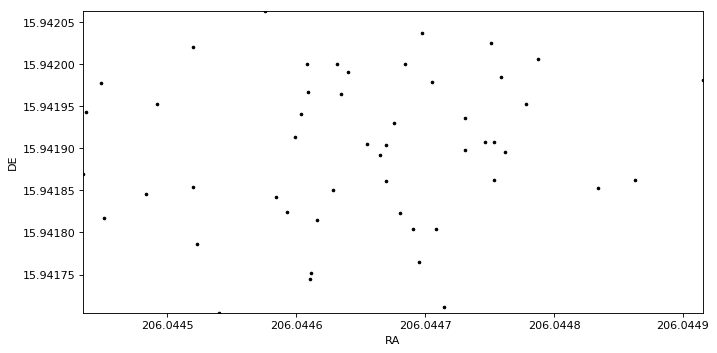

In [10]:
coords = sgl_position_scatter(
    RA=RA,
    e_RA=e_RA+e_pmRA*(observation_time-epoch),
    DE=DE,
    e_DE=e_DE+e_pmDE*(observation_time-epoch),
    distance=distance,
    e_distance=distance_uncertainty,
    time=Time(observation_time.value, format='decimalyear'),
    z=1000*u.au,
    n_points=50
    )
fig = plt.figure(figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(coords.ra/u.deg, coords.dec/u.deg, s=5, color='black')
print('Scatter RA (arcsec)', (max(coords.ra/u.deg) - min(coords.ra/u.deg)) * 3600)
print('Scatter DE (arcsec)', (max(coords.dec/u.deg) - min(coords.dec/u.deg)) * 3600)
plt.xlim(min(coords.ra/u.deg), max(coords.ra/u.deg))
plt.ylim(min(coords.dec/u.deg), max(coords.dec/u.deg))
plt.ticklabel_format(useOffset=False)
plt.xlabel('RA')
plt.ylabel('DE');

Create apparent positional movement of SGL receiver probe over a few days, for a range of z. Each line gives the position of the SGL for a specific day. The position on the line is a function of z. Jitter is astrometric uncertainty (almost invisibly small). Determine effect of 1 au wide orbit, observations set apart by 5 days. Effect is much larger than astrometric uncertainty. Add background image from PanSTARRS. Pan image was taken in 2015 and shows uncorrected proper motion effects.

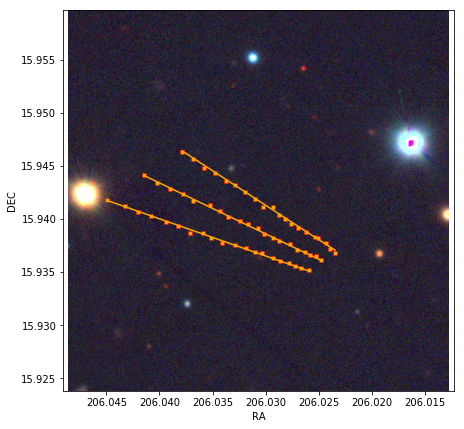

In [11]:
orbit_axis = 1 * u.au  # transmitter around host star
heliocentric_z_array = np.geomspace(1000, 2500, 20) * u.au
times = np.linspace(2020.2, 2020.2 + 9/365, 3) * u.yr
plt.figure(figsize=(7, 7))
ax = plt.gca()
for observation_time in times:
    coords_collection = []
    for z in heliocentric_z_array:
        coords = sgl_position_scatter(
            RA=RA,
            e_RA=e_RA+e_pmRA*(observation_time-epoch),
            DE=DE,
            e_DE=e_DE+e_pmDE*(observation_time-epoch),
            distance=distance,
            e_distance=distance_uncertainty,
            time=Time(observation_time.value, format='decimalyear'),
            orbit_axis=orbit_axis,
            z=z,
            n_points=1
            )
        plt.scatter(
            coords.ra/u.deg,
            coords.dec/u.deg,
            facecolors='orange',
            edgecolors='red',
            linewidths=0.5,
            s=10,
            marker='s'
            )
        coords_noise_free = sgl_position_scatter(
            RA=RA,
            e_RA=0,
            DE=DE,
            e_DE=0,
            distance=distance,
            e_distance=0,
            time=Time(observation_time.value, format='decimalyear'),
            z=z,
            n_points=1
            )
        coords_collection.append(coords_noise_free)
        ras = SkyCoord(coords_collection).ra / u.deg
        des = SkyCoord(coords_collection).dec / u.deg
    plt.plot(ras, des, color='orange')

# Add background image from PanSTARRS
size = 500
platescale = 0.258  # arcsec per pixel
size_in_degree = (size * platescale) / 3600
center_ra = min(ras) + (max(ras) - min(ras)) / 2
center_de = min(des) + (max(des) - min(des)) / 2
img_left = center_ra - size_in_degree / 2
img_right = center_ra + size_in_degree / 2
img_upper = center_de - 1 * size_in_degree / 2
img_lower = center_de + 1 * size_in_degree / 2
cim = getcolorim(center_ra, center_de, size=size, filters="ugriz", format='png')
ax.imshow(cim, extent=[img_right, img_left, img_upper, img_lower], interpolation='bilinear')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_xlim(img_right, img_left)
ax.set_ylim(img_upper, img_lower)
ax.ticklabel_format(useOffset=False)
ax.set_aspect('equal', 'datalim');

Make ellipse showing yearly wobble (2022.0 - 2023.0) due to Earth's motion around the sun. One black point per week. First and last points not identical due to proper motion. For week #11, add 10 red points to cover heliocentric $z$ range from 550 to 2500 au.

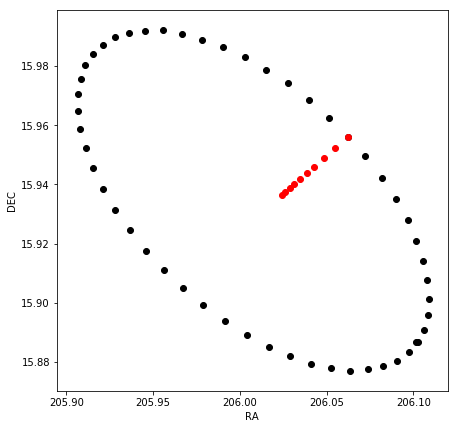

In [12]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

times = np.linspace(2020, 2021, 52) * u.yr
for observation_time in times:
    coords = sgl_position_scatter(
        RA=RA,
        e_RA=e_RA+e_pmRA*(observation_time-epoch),
        DE=DE,
        e_DE=e_DE+e_pmDE*(observation_time-epoch),
        distance=distance,
        e_distance=distance_uncertainty,
        time=Time(observation_time.value, format='decimalyear'),
        orbit_axis=orbit_axis,
        z=550*u.au,
        n_points=1
        )
    plt.scatter(coords.ra/u.deg, coords.dec/u.deg, color='black')

heliocentric_z_array = np.geomspace(550, 2500, 10) * u.au
observation_time = (2020 + 11/51) * u.yr
for z in heliocentric_z_array:
    coords = sgl_position_scatter(
        RA=RA,
        e_RA=e_RA+e_pmRA*(observation_time-epoch),
        DE=DE,
        e_DE=e_DE+e_pmDE*(observation_time-epoch),
        distance=distance,
        e_distance=distance_uncertainty,
        time=Time(observation_time.value, format='decimalyear'),
        orbit_axis=orbit_axis,
        z=z,
        n_points=1
        )
    plt.scatter(coords.ra/u.deg, coords.dec/u.deg, color='red')

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.ticklabel_format(useOffset=False);

Transmitter

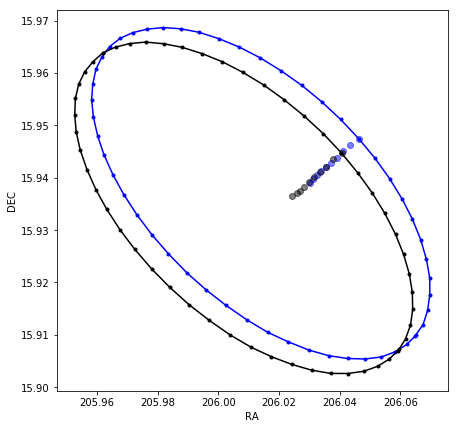

In [13]:
# Light travel time to Tau Ceti
ltt_tau_ceti = distance.to(u.lightyear).value * u.year

# Transmitter PM correction backwards, because probe beams at where Tau Ceti was 12 years ago
plt.figure(figsize=(7, 7))
ax = plt.gca()
times = np.linspace(2020, 2021, 52) * u.yr
list_ras = []
list_des = []
for observation_time in times:
    coords = sgl_position_scatter(
        RA=RA-pmRA*ltt_tau_ceti,
        e_RA=0,
        DE=DE-pmDE*ltt_tau_ceti,
        e_DE=0,
        distance=distance,
        e_distance=distance_uncertainty,
        time=Time((observation_time).value, format='decimalyear'),
        orbit_axis=orbit_axis,
        z=1000*u.au,
        n_points=1
        )
    list_ras.append(coords.ra/u.deg)
    list_des.append(coords.dec/u.deg)
plt.plot(list_ras, list_des, color='blue', marker=".")

heliocentric_z_array = np.geomspace(1000, 2500, 10) * u.au
observation_time = (2020 + 11/51) * u.yr
for z in heliocentric_z_array:
    coords = sgl_position_scatter(
        RA=RA-pmRA*ltt_tau_ceti,
        e_RA=0,
        DE=DE-pmDE*ltt_tau_ceti,
        e_DE=0,
        distance=distance,
        e_distance=distance_uncertainty,
        time=Time(observation_time.value, format='decimalyear'),
        orbit_axis=orbit_axis,
        z=z,
        n_points=1
        )
    plt.scatter(coords.ra/u.deg, coords.dec/u.deg, color='blue', alpha=0.5);
    
###################################
# Receiver
times = np.linspace(2020, 2021, 52) * u.yr
list_ras = []
list_des = []
for observation_time in times:
    coords = sgl_position_scatter(
        RA=RA,
        e_RA=0,
        DE=DE,
        e_DE=0,
        distance=distance,
        e_distance=distance_uncertainty,
        time=Time(observation_time.value, format='decimalyear'),
        orbit_axis=orbit_axis,
        z=1000*u.au,
        n_points=1
        )
    list_ras.append(coords.ra/u.deg)
    list_des.append(coords.dec/u.deg)
plt.plot(list_ras, list_des, color='black', marker=".")

heliocentric_z_array = np.geomspace(1000, 2500, 10) * u.au
observation_time = (2020 + 11/51) * u.yr
for z in heliocentric_z_array:
    coords = sgl_position_scatter(
        RA=RA,
        e_RA=e_RA+e_pmRA*(observation_time-epoch),
        DE=DE,
        e_DE=e_DE+e_pmDE*(observation_time-epoch),
        distance=distance,
        e_distance=distance_uncertainty,
        time=Time(observation_time.value, format='decimalyear'),
        orbit_axis=orbit_axis,
        z=z,
        n_points=1
        )
    plt.scatter(coords.ra/u.deg, coords.dec/u.deg, color='black', alpha=0.5);
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.ticklabel_format(useOffset=False)

Probes at very large heliocentric distances $z$ have significant light time travel effects (between probe and Earth). They do not appear on a straight line any more. Relevant only for very large $z \gtrsim 5000$ (red points). Such large $z$ values are not expected in practice.

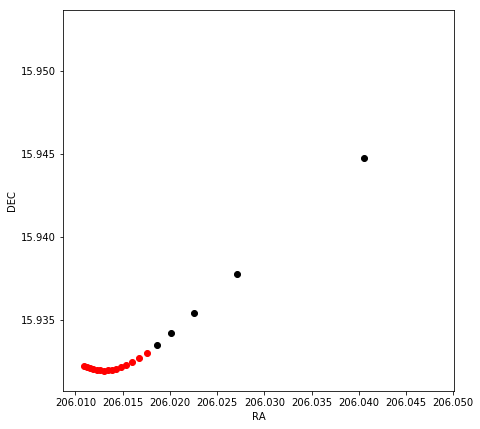

In [14]:
plt.figure(figsize=(7, 7))
ax = plt.gca()
heliocentric_z_array = np.linspace(1000, 20000, 20) * u.au
observation_time = (2020 + 11/51) * u.yr
for z in heliocentric_z_array:
    coords = sgl_position_scatter(
        RA=RA,
        e_RA=0,
        DE=DE,
        e_DE=0,
        distance=distance,
        e_distance=distance_uncertainty,
        time=Time(observation_time.value, format='decimalyear'),
        orbit_axis=0*u.au,
        z=z,
        n_points=1
        )
    if z / u.au > 5000:
        color = 'red'
    else:
        color = 'black'
    plt.scatter(coords.ra/u.deg, coords.dec/u.deg, color=color)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.ticklabel_format(useOffset=False)